# Colab google drive mount

In [ ]:
# Colab
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CZ4042 Assign 1')

Mounted at /content/drive


# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [ ]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_x0m1ahn
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-_x0m1ahn
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184222 sha256=8ecfb05072995a0c941271558fb076371472c5c6f75d41f3a3478016342161a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-t8hs2ihr/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [ ]:
df = pd.read_csv('./full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [ ]:
df['label'] = df['filename'].str.split('_').str[-2]

In [ ]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

Split and scale dataset

In [ ]:

columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

Represent `y_train` and `y_test` into category encoding.

# ***Given codes above***
---
# ***My codes start here***

## Since we are doing classification, convert the labels into one-hot vector.

Also instead of using `X_train` and `X_test`, I will be using `X_train_scaled` and `X_test_scaled`.

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Question 1

## Create model

Architecture:
- An input layer.
- **Three** hidden layers of **128** neurons each with **ReLU** activation function.
- An output layer with **sigmoid** activation function.

Hyper-parameters:

- ***batch size***: 256

- ***learning rate***: 0.001

- ***dropout rate***: 0.2

Optimizer: ***adam***


In [ ]:
# Hyper-parameters definitions
num_hidden = 128
learning_rate = 0.001
dropout_rate = 0.2
batch_size = 256
epoch_num = 100
num_labels = y_train.shape[1]
num_features = X_train.shape[1]
# activation function definitions
hidden_activation = 'relu'
output_activation = 'sigmoid'

# Architecture and training method
def get_model():
  ret = keras.models.Sequential([
      keras.layers.Dense(num_hidden, activation = hidden_activation), keras.layers.Dropout(dropout_rate), # ---
      keras.layers.Dense(num_hidden, activation = hidden_activation), keras.layers.Dropout(dropout_rate), # --├ 128 neurons with dropout 0.2 hidden layers * 3
      keras.layers.Dense(num_hidden, activation = hidden_activation), keras.layers.Dropout(dropout_rate), # ---
      keras.layers.Dense(num_labels, activation = output_activation) # -- output layer
  ])
  ret.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
  )
  return ret


## Q1-a

In [ ]:
# Create a fresh model
model = get_model()

init a tensorflow callback routine with `patience = 3`

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)]

train the model using scaled features

In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    epochs = epoch_num,
    batch_size = batch_size,
    callbacks = callbacks,
    verbose = 0,
    validation_data = (X_test_scaled, y_test)
  )
epoch_actual = len(history.history['loss'])
print(f'Trained {epoch_actual}/{epoch_num} rounds')

Trained 62/100 rounds


## Q1-b

In [ ]:
histories = {}
histories['Q1-a'] = history

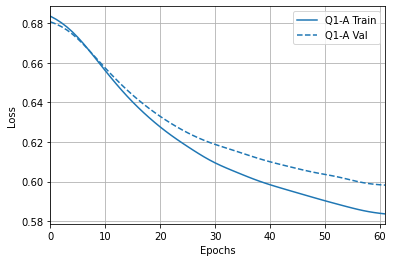

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(histories)

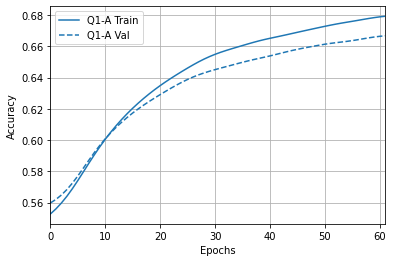

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)

To explain the `EarlyStop` usage here, lets train a new model without it.

In [ ]:
model = get_model() # get a fresh model
history = model.fit( # same training but without EarlyStop
    X_train_scaled, y_train,
    epochs = epoch_num,
    batch_size = batch_size,
    verbose = 0,
    validation_data = (X_test_scaled, y_test)
  )
epoch_actual = len(history.history['loss'])
print(f'Trained {epoch_actual}/{epoch_num} rounds')
histories['Q1-b'] = history

Trained 100/100 rounds


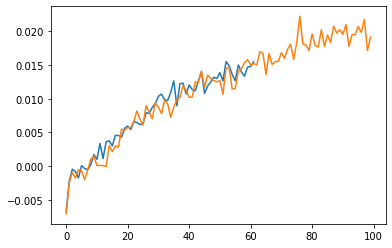

In [ ]:
loss_diff_earlystop = np.asarray(histories['Q1-a'].history['val_loss']) - np.asarray(histories['Q1-a'].history['loss'])
loss_diff = np.asarray(histories['Q1-b'].history['val_loss']) - np.asarray(histories['Q1-b'].history['loss'])
plt.plot(range(len(loss_diff_earlystop)), loss_diff_earlystop)
plt.plot(range(len(loss_diff)), loss_diff)

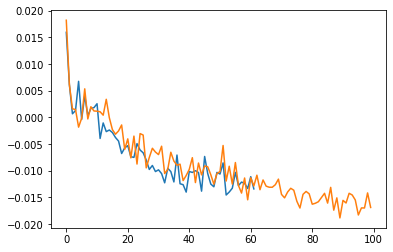

In [ ]:
acc_diff_earlystop = np.asarray(histories['Q1-a'].history['val_accuracy']) - np.asarray(histories['Q1-a'].history['accuracy'])
acc_diff = np.asarray(histories['Q1-b'].history['val_accuracy']) - np.asarray(histories['Q1-b'].history['accuracy'])
plt.plot(range(len(acc_diff_earlystop)), acc_diff_earlystop)
plt.plot(range(len(acc_diff)), acc_diff)

By observing the graph above, the use of `EarlyStop` in this question can be found in two aspects.

Compare non-EarlyStopped model with EarlyStopped model:

1. The difference between train loss/accuracy and validation loss/accuacy became greater as we continue training, which implies that there might be a potential overfitting problem.
2. Although we can find that althought the validatioin loss is decreasing if we continue training, it is decreasing much slower, by EarlyStopping we can save time and resources of training.


# Question 2

Definition of hyper parameters:

- Fold number: 5

- Search space of batch size: {128, 256, 512, 1024}

In [ ]:
num_folds = 5
cv = KFold(n_splits=num_folds, shuffle=True, random_state=1)
batch_size_iter = [128, 256, 512, 1024]
# get the complete dataset
X_scaled = np.concatenate([X_train_scaled, X_test_scaled])
y = np.concatenate([y_train, y_test])


## Q2-a & Q2-b

Define a `CallBack` which logs the duration of each epoch.


In [ ]:
class LastEpochCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    self.durations = []
    self.begin = None

  def on_epoch_begin(self, epoch, logs = None):
    self.begin = time.time()

  def on_epoch_end(self, epoch, logs = None):
    self.durations.append(time.time() - self.begin)

For each batch size, train a model using K-fold cross validation.

Training parameter is the same as `Q1-a`.


In [ ]:
# record average training data for each batch size
accuracy_his = []
lastEpochDurations = []
avgEpochNums = []

for batch_size in batch_size_iter:
  # his data for each fold
  _acc = []
  _duration = []
  _epoch = []
  for train_idx, test_idx in cv.split(X_scaled, y):
    model = get_model()
    X_train_splited, X_test_splited = X_scaled[train_idx], X_scaled[test_idx]
    y_train_splited, y_test_splited = y[train_idx], y[test_idx]
    myCallBack = LastEpochCallback()
    his = model.fit(
        X_train_splited, y_train_splited,
        epochs = epoch_num,
        batch_size = batch_size,
        verbose = 0,
        callbacks = callbacks + [myCallBack],
        validation_data = (X_test_splited, y_test_splited)
    )
    _acc.append(his.history['val_accuracy'][-1])
    _duration.append(myCallBack.durations[-1])
    _epoch.append(len(his.history['loss']))
  accuracy_his.append(np.mean(_acc))
  lastEpochDurations.append(np.mean(_duration))
  avgEpochNums.append(np.mean(_epoch))

### Q2-a result

In [ ]:
batch_size_iter, accuracy_his

([128, 256, 512, 1024],
 [0.6662405133247375,
  0.6686327576637268,
  0.6725668549537659,
  0.6716670393943787])

Scatter plot of accuracy versus batch size

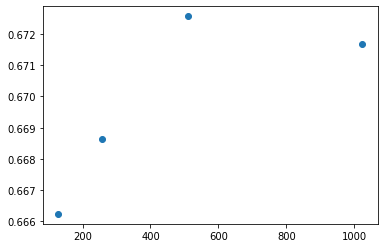

In [ ]:
plt.scatter(batch_size_iter, accuracy_his)

In [ ]:
for i in range(len(batch_size_iter)):
  print(f'The average epoch number of the last epoch of batch size {batch_size_iter[i]} is {avgEpochNums[i]:.2f}/{epoch_num}')
best_accuracy_batch_size = batch_size_iter[np.argmax(accuracy_his)]
print(f'The batch size with the best accuracyf is {best_accuracy_batch_size}.')

The average epoch number of the last epoch of batch size 128 is 47.40/100
The average epoch number of the last epoch of batch size 256 is 49.20/100
The average epoch number of the last epoch of batch size 512 is 60.80/100
The average epoch number of the last epoch of batch size 1024 is 74.20/100
The batch size with the best accuracyf is 512.


### Q2-b result

In [ ]:
for i in range(len(batch_size_iter)):
  print(f'The duration of the last epoch of batch size {batch_size_iter[i]} is {lastEpochDurations[i]:.2f} s')

The duration of the last epoch of batch size 128 is 4.48 s
The duration of the last epoch of batch size 256 is 3.32 s
The duration of the last epoch of batch size 512 is 2.52 s
The duration of the last epoch of batch size 1024 is 2.15 s


## Q2-c

By **running multiple experiments** and observation, the larger batch size tends to have better validation loss/accuracy and less trainning time, but if the batch size becomes too large, we mighr expected an accuracy decrease.

In [ ]:
# set batch size to optimal
batch_size = best_accuracy_batch_size

## Q2-d

As batch size increases:
1. The validation accuracy/trained epoches increases.
2. The training & converging speed increases.

My explanations:
1. When batch size is too small, the randomness when choosing batch data increases (since you might not catch the 'whole picture' of the training data in such a small batch), which makes it harder for the model to converge.

2. When increasing the batch size, the computational efficiency increases since larger batch better utilizes the large matrix calculation as well as parallel computation and memory usage.

## Q2-e

In [ ]:
model = get_model()
print(f'current batch size: {batch_size}')
history = model.fit(
    X_train_scaled, y_train,
    epochs = epoch_num,
    batch_size = batch_size,
    callbacks = callbacks,
    verbose = 0,
    validation_data = (X_test_scaled, y_test)
  )
epoch_actual = len(history.history['loss'])
print(f'Trained {epoch_actual}/{epoch_num} rounds')
histories = {}
histories['Q2-e'] = history

current batch size: 512
Trained 57/100 rounds


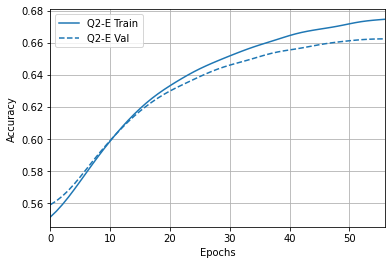

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)

# Question 3

Define a first-hidden-layer-configurable model for Q3

In [ ]:
# Architecture and training method
def get_model_Q3(num_first_hidden):
  ret = keras.models.Sequential([
      keras.layers.Dense(num_first_hidden, activation = hidden_activation), keras.layers.Dropout(dropout_rate), # --- the width of first hidden layer is changable
      keras.layers.Dense(num_hidden, activation = hidden_activation), keras.layers.Dropout(dropout_rate), # --├ 128 neurons with dropout 0.2 hidden layers * 3
      keras.layers.Dense(num_hidden, activation = hidden_activation), keras.layers.Dropout(dropout_rate), # ---
      keras.layers.Dense(num_labels, activation = output_activation) # -- output layer
  ])
  ret.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
  )
  return ret

Similar to Q2 K-fold training

In [ ]:
num_folds = 5
cv = KFold(n_splits=num_folds, shuffle=True, random_state=1)
num_first_hidden_iter = [64, 128, 256]
X_scaled = np.concatenate([X_train_scaled, X_test_scaled])
y = np.concatenate([y_train, y_test])
accuracy_his = []
lastEpochDurations = []
avgEpochNums = []

## Q3-a

In [ ]:
for num_first_hidden in num_first_hidden_iter:
  _acc = []
  _duration = []
  _epoch = []
  for train_idx, test_idx in cv.split(X_scaled, y):
    model = get_model_Q3(num_first_hidden)
    X_train_splited, X_test_splited = X_scaled[train_idx], X_scaled[test_idx]
    y_train_splited, y_test_splited = y[train_idx], y[test_idx]
    myCallBack = LastEpochCallback()
    his = model.fit(
        X_train_splited, y_train_splited,
        epochs = epoch_num,
        batch_size = batch_size,
        verbose = 0,
        callbacks = callbacks + [myCallBack],
        validation_data = (X_test_splited, y_test_splited)
    )
    _acc.append(his.history['val_accuracy'][-1])
    _duration.append(myCallBack.durations[-1])
    _epoch.append(len(his.history['loss']))
  accuracy_his.append(np.mean(_acc))
  lastEpochDurations.append(np.mean(_duration))
  avgEpochNums.append(np.mean(_epoch))

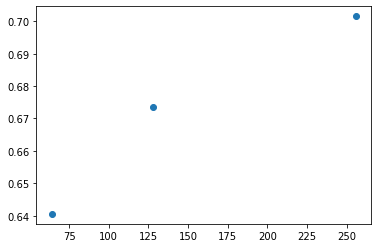

In [ ]:
plt.scatter(num_first_hidden_iter, accuracy_his)

## Q3-b

In [ ]:
for i in range(len(num_first_hidden_iter)):
  print(f'The average epoch number of the last epoch of hidden neuron number {num_first_hidden_iter[i]} is {avgEpochNums[i]:.2f}/{epoch_num}')
best_accuracy_num_first_hidden = num_first_hidden_iter[np.argmax(accuracy_his)]
print(f'The optimal number of hidden neurons for first hidden layer with the best accuracy is {best_accuracy_num_first_hidden}.')

The average epoch number of the last epoch of hidden neuron number 64 is 58.60/100
The average epoch number of the last epoch of hidden neuron number 128 is 65.60/100
The average epoch number of the last epoch of hidden neuron number 256 is 63.00/100
The optimal number of hidden neurons for first hidden layer with the best accuracy is 256.


In [ ]:
# set num_hidden to the optimal, this global variable is used in get_model()
num_hidden = best_accuracy_num_first_hidden

## Q3-c

In [ ]:
model = get_model() # get a fresh model
history = model.fit(
    X_train_scaled, y_train,
    epochs = epoch_num,
    batch_size = batch_size,
    verbose = 0,
    callbacks = callbacks,
    validation_data = (X_test_scaled, y_test)
  )
histories = {}
histories['Q3-c'] = history

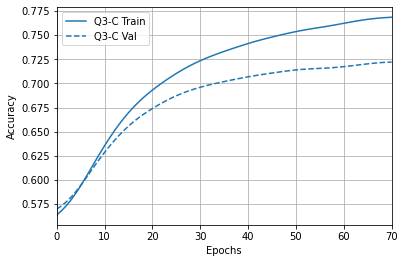

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)

## Q3-d

I did some search on stack overflow and here are my conclusions (not from a very mathematical perspective):


The dropout is trying to avoid overfitting the model by adding some noise into the model. 
 - We determine a hyper-parameter *`P`*, for each neuron with input *`h`*, we set the output `h'` to 0 with the probability *`P`*, and to *`h/1-P`* with the probability *`1-P`*. 
 - For each neuron output *`h'`*, the expectation of *`h'`*, which is `E[h'] = 0*P + h/1-P * 1-P = h`

By this design, the expectation of output doesn't change while the robust of the model increases.

## Q3-e

For example, L1 and L2 normalization, batch normalization.

Here I try to implement L2 normalization (with a weight of `0.0001`).

The calculation of loss will take the weight into consideration so that the weight is closer to 0 (or smaller absolute value), which makes the model "simpler" and less overfitted. 

In [ ]:
from keras.regularizers import l2

l2_weight = 0.0001

# similar to get_model, but with l2
model = keras.models.Sequential([
      keras.layers.Dense(num_hidden, activation = hidden_activation, kernel_regularizer=l2(l2_weight)), keras.layers.Dropout(dropout_rate), # ---
      keras.layers.Dense(num_hidden, activation = hidden_activation, kernel_regularizer=l2(l2_weight)), keras.layers.Dropout(dropout_rate), # --├ 128 neurons with dropout 0.2 hidden layers * 3
      keras.layers.Dense(num_hidden, activation = hidden_activation, kernel_regularizer=l2(l2_weight)), keras.layers.Dropout(dropout_rate), # ---
      keras.layers.Dense(num_labels, activation = output_activation) # -- output layer
  ])
model.compile(
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
  loss = keras.losses.CategoricalCrossentropy(),
  metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    epochs = epoch_num,
    batch_size = batch_size,
    verbose = 0,
    callbacks = callbacks,
    validation_data = (X_test_scaled, y_test)
  )
histories = {}
histories['Q3-e'] = history

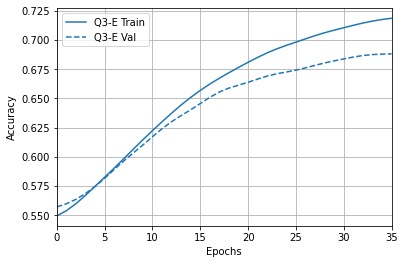

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)

# Question 4

## Q4-a & Q4-b

In [ ]:
# the model from Q3-e
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 256)               19968     
                                                                 
 dropout_117 (Dropout)       (None, 256)               0         
                                                                 
 dense_157 (Dense)           (None, 256)               65792     
                                                                 
 dropout_118 (Dropout)       (None, 256)               0         
                                                                 
 dense_158 (Dense)           (None, 256)               65792     
                                                                 
 dropout_119 (Dropout)       (None, 256)               0         
                                                                 
 dense_159 (Dense)           (None, 2)               

In [ ]:
my_record = pd.read_csv('./new_record.csv') 
my_record = my_record.drop(['filename'], axis = 1)
my_record.head()

,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,151.999081,806,100.75,0.484173,0.089755,0.427731,0.070291,0.246934,0.022357,0.033672,...,-1.758633,84.99933,-11.126899,113.766495,5.894416,100.56858,0.442396,69.694046,-4.330632,43.631893


In [ ]:
my_record_scaled, _ = preprocess_dataset(my_record, my_record)

In [ ]:
my_record_prediction = model.predict(my_record_scaled)

In [ ]:
my_record_classification = my_record_prediction > 0.5

In [ ]:
my_record_prediction, my_record_classification

(array([[0.463475  , 0.52671987]], dtype=float32), array([[False,  True]]))

## Q4-c

In [ ]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [ ]:
explainer = shap.DeepExplainer(model, X_train_scaled)
shap_values = explainer.shap_values(my_record_scaled)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
array([[-0.98188845, -0.66652426, -0.50251035, ..., -0.71452695,
         1.13479713, -0.96121638],
       [ 1.8977701 ,  0.30288644,  0.20423714, ...,  0.09663193,
         0.53793319, -0.39115457],
       [ 0.22756814, -0.60304792, -0.74124732, ...,  0.55786375,
         0.85330671,  0.52734208],
       ...,
       [-0.98188845, -0.71222723, -0.9670796 , ...,  2.79995053,
        -0.4349303 ,  2.32059267],
       [-0.12671712,  2.07286078,  1.99583986, ..., -0.43870178,
        -0.55521336, -0.41269647],
       [-0.12671712,  1.05927054,  1.36123826, ...,  0.40455881,
        -1.59415278, -0.4228941 ]])>]. Consider rewriting this model with the Functiona

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = my_record.columns)

Observations:
- The plot shows a prediction of `neg` possibility regarding my recording.
- `mfcc12_mean` contributes most to higher `neg` prediction and `mfcc14_mean` contributes most to lower `neg` prediction.
- `mfcc` values are important features in the model, they almost dominate prediction of the model.
- Besides `mfcc`, `cent_var` is also  an important feature and contribute to higher `neg`.

Explanation:

It can be expected that `mfcc` are important features since they `concisely describe the overall shape of a spectral envelope`, which contains a lot of information of original waves.


# Discussion

1. We now have a classifier that predicts the speech polarity. What are some
limitations of the current approach (using FFNs to model such engineered features)? 
  - The model is not trying to "understand" the relationship between features and label, instead, it only finds a mapping between them. If input contains some new features, such infomation can be neglected; if input belongs to a different distribution from trainning data (differenct accent, for example), the model might give the wrong prediction.

2. Out of the parameters that were tuned, which was most impactful in terms of
improving the model performance and what could be some reasons for that?
  - Neurons number of layer: increasing the neurons layer might improves the capacity of a model, which means the model will be able to capture more features and utilize them. However, if the neurons are too many, overfitting and dead neurons might happen.

3. Considering that audio tracks are originally waveforms, what are some alternative approaches to achieve the goal of genre classification? What kind of neural network architectures will be used instead?
  - The audio tracks can be treated as time series and we can apply a recurrent neural network on it.

4. What other datasets and tasks can this approach of modelling waveform data be used for? What changes to the pipeline, if any, will you have to make when
approaching these problems?
  - Datasets: [Mozilla Common Voice](https://commonvoice.mozilla.org/en/datasets)
  - Task: guessing the gender of the speaker
  - Need to label the possible gender of the given voice.
  - Need to preprocess the data to get some fundemental features (like volume, speed, pitch, intonation...)